**Projeto da disciplina de Data Mining**

**PESC - Programa de Engenharia de Sistemas e Computação**

**COPPE / UFRJ**

Autor: Rafael Lopes Conde dos Reis

E-mail: condereis@cos.ufrj.br 

GitHub: https://github.com/condereis/data-mining

# Resumo

O trabalho consiste em analisar a aplicação da técnica K-means para clusterizar os filmes da base do MovieLens. Deve-se observar os clusters gerados para diferentes valores de k (15-30), assim como antes e depois de executar redução de dimensionalidade, com PCA (10-15 dimensões).

# Pacotes Utilizados

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fancyimpute import MICE 
from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA

%matplotlib inline

Using Theano backend.


# Pré-processamento

A base fornecida pelo MovieLens contém 100.004 avaliações, feitas por 671 usuários, referentes a 9.125 filmes. Ela possui 4 colunas (userId, movieId, rating e timestamp) e 100.004 linhas, como pode ser visto abaixo. O pré-processamento irá gerar um dataframe *filmes x usuários* e irá avaliar o desempenho de diferentes formas de substituir os valores NaNs (filmes que não foram avaliados por um dado usuário).

In [2]:
raw_data = pd.read_csv('../data/movielens/ratings.csv')
raw_data.tail()

,userId,movieId,rating,timestamp
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663
100003,671,6565,3.5,1074784724


O site também disponibiliza uma base associando os movieIds aos títulos e gêneros dos respectivos filmes, exibida abaixo.

In [3]:
movie_titles = pd.read_csv('../data/movielens/movies.csv')
movie_titles.tail()

,movieId,title,genres
9120,162672,Mohenjo Daro (2016),Adventure|Drama|Romance
9121,163056,Shin Godzilla (2016),Action|Adventure|Fantasy|Sci-Fi
9122,163949,The Beatles: Eight Days a Week - The Touring Y...,Documentary
9123,164977,The Gay Desperado (1936),Comedy
9124,164979,"Women of '69, Unboxed",Documentary


Gerando o dataframe *filmes x usuários* e concatenando a informação dos filmes chegamos ao dataframe abaixo:

In [4]:
# Dataframe com colunas identificadas pelos ids dos filmes
ratings_df = pd.DataFrame(
    columns=raw_data.movieId.sort_values().unique())

for index, row in raw_data.iterrows():
    ratings_df.set_value(row.userId, row.movieId, row.rating)

A dimensão do dataframe se mantem a mesma (desconsiderando o fato de que foi transposto) após tentar remover linhas ou colunas que sejam apenas NaN, ou seja, não há nenhum filme que não tenha sido avaliado pelo menos por um usuário, nem nenhum usuário que não tenha avaliado ao menos um filme. 

In [5]:
print ratings_df.shape
ratings_df = ratings_df.dropna(axis=0, how='all').dropna(
    axis=1, how='all').T
print ratings_df.shape

(671, 9066)
(9066, 671)


Foram testadas 4 formas de substituir os valores faltantes:

* Substituir pela média das notas do filme
* Substituir pela média das notas do usuário
* Substituir pela metade da nota máxima (2.5)

A cada dataset foi aplicado k-means com k=15 e observada a soma da distância dos pontos aos centroides dos clusters. Para tentar se aproximar do mínimo global cada teste foi repetido 10 vezes e o melhor resultado considerado. Como pode-se ver no gráfico abaixo 

Serão treinados 15 modelos diferentes, variando o número de clusters entre 15 e 30. Para cada modelo foram feitas 10 inicializações (n_init=10) e escolhida a melhor, para tentar encontrar um modelo mais próximo do mínimo global, uma vez que k-means apenas garante convergência para um mínimo local. A inicialização usada foi a k-means++, que inicia os centroides afastados uns dos outros, o que tende a garantir melhores resultados que uma inicialização aleatória [1].

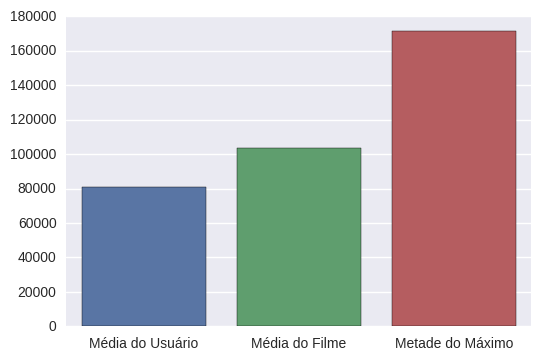

In [6]:
score=[]
method=[]
kmeans = KMeans(n_clusters=15, init='k-means++', n_init=10, 
                n_jobs=-1)

# Substitui NaNs pela média das notas do usuário
fill_by_user = ratings_df.fillna(ratings_df.mean())
score.append(-kmeans.fit(fill_by_user).score(fill_by_user))
method.append(u'Média do Usuário')

# Substitui NaNs pela média das notas do filme
fill_by_movie = ratings_df.T.fillna(ratings_df.T.mean()).T
score.append(-kmeans.fit(fill_by_movie).score(fill_by_movie))
method.append(u'Média do Filme')

# Substitui NaNs por 2.5
fill_by_mean = ratings_df.fillna(2.5)
score.append(-kmeans.fit(fill_by_mean).score(fill_by_mean))
method.append(u'Metade do Máximo')
sns.barplot(method, score);

Os demais estudos aqui realizados usaram os a média do usuário para substituir os NaNs, por ter permitido uma melhor clusterização que os demais.

In [7]:
# Salva o dataframe em arquivo para facilitar o acesso
fill_by_user.to_csv('../data/movielens/input.csv',
                  index=False)
del fill_by_user
del fill_by_movie
del fill_by_mean
del ratings_df

# Clusterização sem Redução de Dimensionalidade
O primeiro passo é aplicas k-means a matriz de dados completa, sem nenhuma forma de redução de dimensionalidade.

In [8]:
X = pd.read_csv('../data/movielens/input.csv')

Foram treinados 15 modelos diferentes, variando o número de clusters entre 15 e 30. Para cada modelo foram feitas 10 inicializações (n_init=10) e escolhida a melhor, para tentar encontrar um modelo mais próximo do mínimo global, uma vez que k-means apenas garante convergência para um mínimo local. A inicialização usada foi a k-means++, que inicia os centroides afastados uns dos outros, o que tende a garantir melhores resultados que uma inicialização aleatória [1].

In [29]:
score_list = []
for k in range(15,31):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10,
                    n_jobs=-1).fit(X)
    score_list.append(-kmeans.score(X))

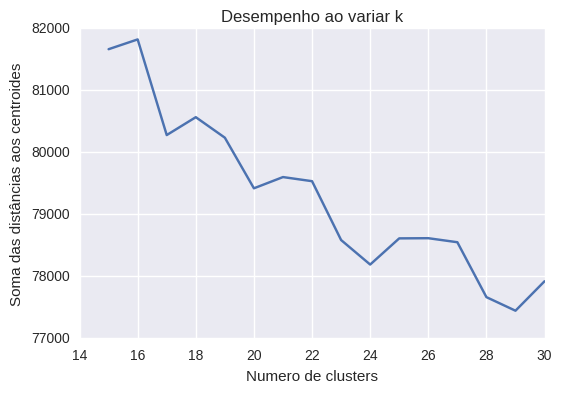

In [30]:
plt.plot(range(15,31), score_list)
plt.title('Desempenho ao variar k')
plt.xlabel('Numero de clusters')
plt.ylabel(u'Soma das distâncias aos centroides')

Como esperado a soma das distâncias para o centros dos clusters diminui com o aumento do numero de clusters. Houve um salto grande da soma ao mudar k de 22 para 23, o que pode ser um indicativo de um bom valor para k.Portanto analisados em detalhe os modelos com 15, 23 e 30 clusteres. Para cada um foi plotado a distribuição de eventos por cluster assim como os filmes que ficaram no mesmo cluster de *Star Wars: Episode IV - A New Hope (1977)*.

### 15 clusters

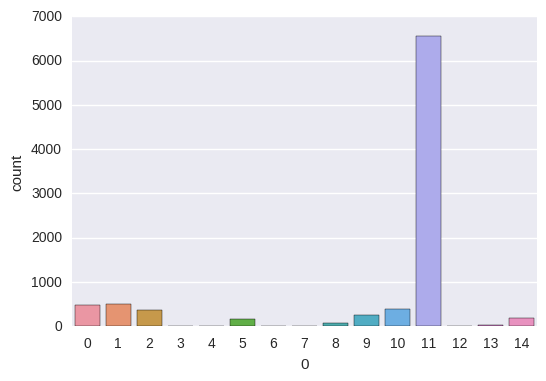

In [11]:
kmeans = KMeans(n_clusters=15, init='k-means++', n_init=20,
                    n_jobs=-1).fit(X)
predict = pd.Series(kmeans.predict(X), index=X.index)
predict.head()
out = pd.concat([predict, movie_titles], axis=1, join='inner')
sns.countplot(out[0])

In [31]:
cluster_starwars = out[out['movieId']==260][0].tolist()[0]
out[out[0]==cluster_starwars]

,0,movieId,title,genres
232,20,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
953,20,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
955,20,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure
966,20,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi


### 23 Clusters

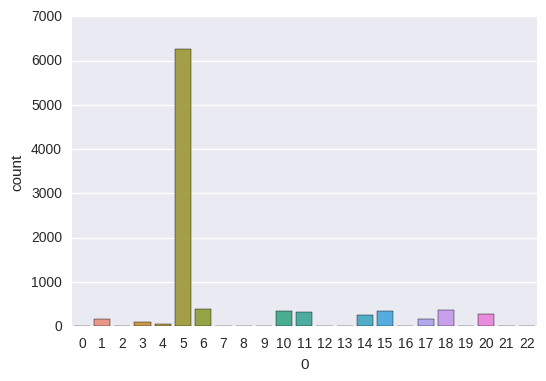

In [13]:
kmeans = KMeans(n_clusters=23, init='k-means++', n_init=20,
                    n_jobs=-1).fit(X)
predict = pd.Series(kmeans.predict(X), index=X.index)
predict.head()
out = pd.concat([predict, movie_titles], axis=1, join='inner')
sns.countplot(out[0])

In [14]:
cluster_starwars = out[out['movieId']==260][0].tolist()[0]
out[out[0]==cluster_starwars]

,0,movieId,title,genres
232,13,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
953,13,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
955,13,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure
966,13,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi


### 30 Clusters

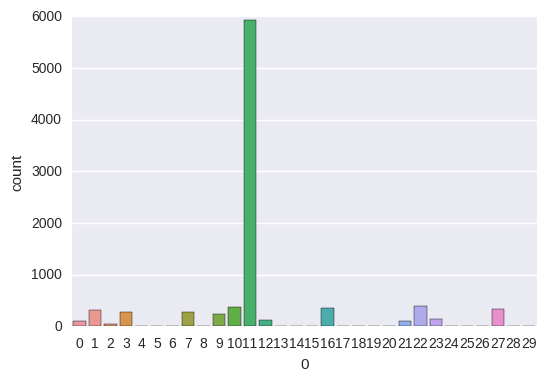

In [15]:
kmeans = KMeans(n_clusters=30, init='k-means++', n_init=20,
                    n_jobs=-1).fit(X)
predict = pd.Series(kmeans.predict(X), index=X.index)
predict.head()
out = pd.concat([predict, movie_titles], axis=1, join='inner')
sns.countplot(out[0])

In [16]:
cluster_starwars = out[out['movieId']==260][0].tolist()[0]
out[out[0]==cluster_starwars]

,0,movieId,title,genres
232,4,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
953,4,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
955,4,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure
966,4,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi


É possível observar que tanto com 23 quanto com 30 clusters existem vários clusters com muito poucos filmes. Isso pode ser positivo, pois facilita encontrar padrões, mas pode ser negativo criando clusters muito especialistas. O cluster de *Star Wars* é um exemplo de ambos. Uma vez que todos os modelos conseguiram criar um cluster contendo os filmes de *Star Wars*, foi escolhido usar k=23 para as análises de clusterização, por ter apresentado um salto na eficiência e por ser apresentar uma quantidade intermediária de clusters com poucos filmes.

# Aplicando PCA aos Dados

Para termos uma visualização gráfica dos dados clusterizados foi aplicada PCA com 2 dimensões. É possível observar um comportamento peculiar na distribuição. Os dados parecem se organizar em uma reta no plano gerado pela PCA. Podemos ver também que existem aproximadamente 10 agrupamentos, o que pode indicar que isso representa a nota média de cada filme. Como agrupar pela média não traz informações relevantes ao problema, é possível concluir que aplicar a PCA com dimensões próximas a 1, não irá contribuir para chegar a bons clusters.

(9066, 2)


([], <a list of 0 Text yticklabel objects>)

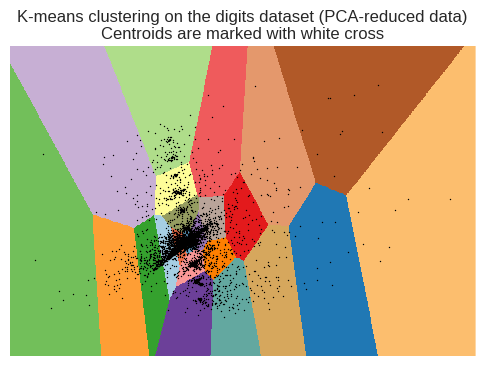

In [17]:
reduced_data = PCA(n_components=2).fit_transform(X)
kmeans = KMeans(init='k-means++', n_clusters=23, n_init=10)
kmeans.fit(reduced_data)
print reduced_data.shape
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X

plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

Variando o número de dimensões de 1 a 30 podemos observar que o desempenho do kmeans aumenta conforme o número de dimensões diminui. Porém como observamos anteriormente, diminuir muito o número de dimensões pode nos levar a agrupar pela média do filme. 

In [18]:
score_list = []
for n_comp in range(1,30):
    pca = PCA(n_components=n_comp, svd_solver='arpack')
    matrix_reduc = pca.fit_transform(X.transpose())
    kmeans = KMeans(n_clusters=23, init='k-means++', n_init=20,
                    n_jobs=-1).fit(matrix_reduc)
    score_list.append(-kmeans.score(matrix_reduc))

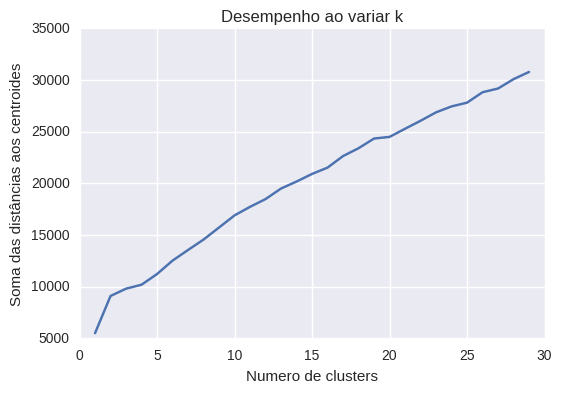

In [19]:
plt.plot(range(1,30), score_list)
plt.title('Desempenho ao variar k')
plt.xlabel('Numero de clusters')
plt.ylabel(u'Soma das distâncias aos centroides')

### 13 Dimensões

In [20]:
pca = PCA(n_components=13, svd_solver='arpack')
matrix_reduc = pca.fit_transform(X)
kmeans = KMeans(n_clusters=23, init='k-means++', n_init=20,
                n_jobs=-1).fit(matrix_reduc)
predict = pd.Series(kmeans.predict(matrix_reduc), index=X.index)
out = pd.concat([predict, movie_titles], axis=1, join='inner')
cluster_starwars = out[out['movieId']==260][0].tolist()[0]
out[out[0]==cluster_starwars]

,0,movieId,title,genres
232,17,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
953,17,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
955,17,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure
966,17,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
2062,17,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
3869,17,4990,Jimmy Neutron: Boy Genius (2001),Adventure|Animation|Children|Comedy
4391,17,5944,Star Trek: Nemesis (2002),Action|Drama|Sci-Fi|Thriller
5017,17,7137,"Cooler, The (2003)",Comedy|Drama|Romance


### 20 Dimensões

In [21]:
pca = PCA(n_components=20, svd_solver='arpack')
matrix_reduc = pca.fit_transform(X)
kmeans = KMeans(n_clusters=23, init='k-means++', n_init=20,
                n_jobs=-1).fit(matrix_reduc)
predict = pd.Series(kmeans.predict(matrix_reduc), index=X.index)
out = pd.concat([predict, movie_titles], axis=1, join='inner')
cluster_starwars = out[out['movieId']==260][0].tolist()[0]
out[out[0]==cluster_starwars]

,0,movieId,title,genres
232,6,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
953,6,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
955,6,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure
966,6,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
2062,6,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
3869,6,4990,Jimmy Neutron: Boy Genius (2001),Adventure|Animation|Children|Comedy
4391,6,5944,Star Trek: Nemesis (2002),Action|Drama|Sci-Fi|Thriller
5017,6,7137,"Cooler, The (2003)",Comedy|Drama|Romance


### 30 Dimensões

In [32]:
pca = PCA(n_components=30, svd_solver='arpack')
matrix_reduc = pca.fit_transform(X)
kmeans = KMeans(n_clusters=23, init='k-means++', n_init=20,
                n_jobs=-1).fit(matrix_reduc)
predict = pd.Series(kmeans.predict(matrix_reduc), index=X.index)
out = pd.concat([predict, movie_titles], axis=1, join='inner')
cluster_starwars = out[out['movieId']==260][0].tolist()[0]
out[out[0]==cluster_starwars]

,0,movieId,title,genres
232,16,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
953,16,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
955,16,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure
966,16,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
2062,16,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
3869,16,4990,Jimmy Neutron: Boy Genius (2001),Adventure|Animation|Children|Comedy
4391,16,5944,Star Trek: Nemesis (2002),Action|Drama|Sci-Fi|Thriller
5017,16,7137,"Cooler, The (2003)",Comedy|Drama|Romance


A variação no número de dimensões não apresentou mudança significativa nos clusters observados. Foi escolhido então usar 13 dimensões uma vez que: um número menor de dimensões apresentou melhor eficiência, o kmeans não funciona bem com muitas dimensões no geral e também menos dimensões facilita o processamento.

# Clusterização com Redução de Dimensionalidade

Variando novamente o número de clusters, após a redução de dimensionalidade, é possível notar que a variação do desempenho foi mais suave. Como esperado, a soma das distâncias aos centros continua diminuindo conforme k aumenta. 

In [23]:
score_list = []
pca = PCA(n_components=13, svd_solver='arpack')
matrix_reduc = pca.fit_transform(X)
for k in range(15,31):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=20,
                    n_jobs=-1).fit(matrix_reduc)
    score_list.append(kmeans.score(matrix_reduc))

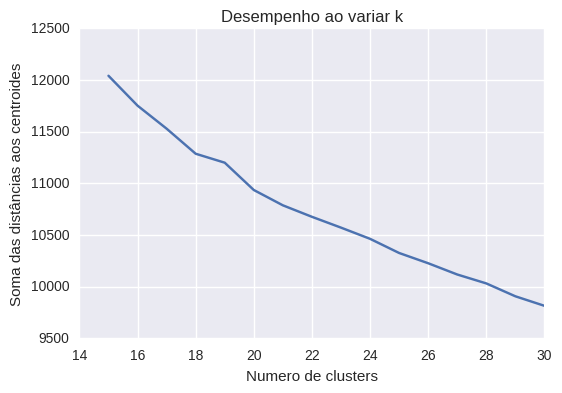

In [24]:
plt.plot(range(15,31), [-x for x in score_list])
plt.title('Desempenho ao variar k')
plt.xlabel('Numero de clusters')
plt.ylabel(u'Soma das distâncias aos centroides')

## Distribuição por Cluster

É possível notar que com redução de dimensionalidade o cluster com maior representatividade passou de ter em torno de 6000 filmes para ter por volta de 5000 filmes. Podemos concluir que de fato reduzir a dimensão ajudou na capacidade do algoritmo de separar os filmes.

### k=15

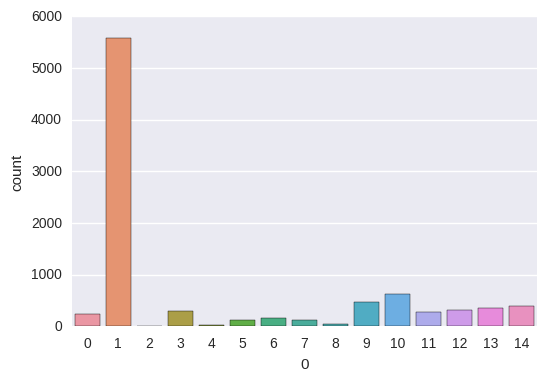

In [52]:
kmeans = KMeans(n_clusters=15, init='k-means++', n_init=20,
                    n_jobs=-1).fit(matrix_reduc)
predict = pd.Series(kmeans.predict(matrix_reduc), index=X.index)
predict.head()
out_15 = pd.concat([predict, movie_titles], axis=1, join='inner')
sns.countplot(out_15[0])

### k=23

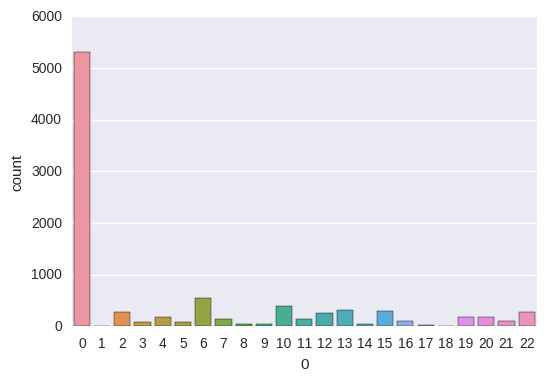

In [26]:
kmeans = KMeans(n_clusters=23, init='k-means++', n_init=20,
                    n_jobs=-1).fit(matrix_reduc)
predict = pd.Series(kmeans.predict(matrix_reduc), index=X.index)
predict.head()
out_23 = pd.concat([predict, movie_titles], axis=1, join='inner')
sns.countplot(out_23[0])

### k=30

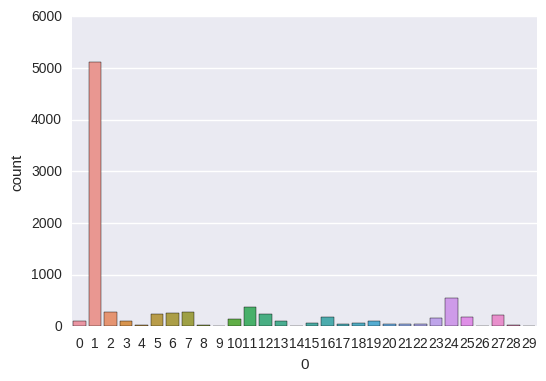

In [27]:
kmeans = KMeans(n_clusters=30, init='k-means++', n_init=20,
                    n_jobs=-1).fit(matrix_reduc)
predict = pd.Series(kmeans.predict(matrix_reduc), index=X.index)
predict.head()
out_30 = pd.concat([predict, movie_titles], axis=1, join='inner')
sns.countplot(out_30[0])

## Análise dos Clusters

Abaixo estão alguns clusters intereçantes encontrados usando k iqual a 15, 23 e 30.

### k=15

#### Cluster Star Wars - Sci-Fi

In [69]:
cluster_starwars = out_15[out_15['movieId']==260][0].tolist()[0]
out_15[out_15[0]==cluster_starwars]

,0,movieId,title,genres
232,2,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
953,2,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
955,2,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure
966,2,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
2062,2,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
3869,2,4990,Jimmy Neutron: Boy Genius (2001),Adventure|Animation|Children|Comedy
4391,2,5944,Star Trek: Nemesis (2002),Action|Drama|Sci-Fi|Thriller
5017,2,7137,"Cooler, The (2003)",Comedy|Drama|Romance


#### Gênero Crime

In [55]:
out_15[out_15[0]==4]

,0,movieId,title,genres
45,4,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
48,4,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
101,4,111,Taxi Driver (1976),Crime|Drama|Thriller
263,4,293,Léon: The Professional (a.k.a. The Professiona...,Action|Crime|Drama|Thriller
266,4,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
284,4,318,"Shawshank Redemption, The (1994)",Crime|Drama
472,4,527,Schindler's List (1993),Drama|War
525,4,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
535,4,608,Fargo (1996),Comedy|Crime|Drama|Thriller
642,4,778,Trainspotting (1996),Comedy|Crime|Drama


#### Gênero Comédia

In [57]:
out_15[out_15[0]==7]

,0,movieId,title,genres
2,7,3,Grumpier Old Men (1995),Comedy|Romance
4,7,5,Father of the Bride Part II (1995),Comedy
18,7,19,Ace Ventura: When Nature Calls (1995),Comedy
44,7,46,How to Make an American Quilt (1995),Drama|Romance
60,7,64,Two if by Sea (1996),Comedy|Romance
61,7,65,Bio-Dome (1996),Comedy
65,7,70,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller
75,7,81,Things to Do in Denver When You're Dead (1995),Crime|Drama|Romance
94,7,102,Mr. Wrong (1996),Comedy
96,7,104,Happy Gilmore (1996),Comedy


### k=23

Usando k=23 Foi possível encontrar um cluster bem representativo para o gênero drama, além dos clusters de comédia, crime e sci-fi já encontrada anteriormente. O cluster crime passou a conter menos filmes. Um deles foi *One Flew Over the Cuckoo's Nest (1975)* que passou corretamente para o cluster drama.

#### Cluster Star Wars - Sci-Fi

In [58]:
cluster_starwars = out_23[out_23['movieId']==260][0].tolist()[0]
out_23[out_23[0]==cluster_starwars]

,0,movieId,title,genres
232,1,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
953,1,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
955,1,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure
966,1,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
2062,1,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
3869,1,4990,Jimmy Neutron: Boy Genius (2001),Adventure|Animation|Children|Comedy
4391,1,5944,Star Trek: Nemesis (2002),Action|Drama|Sci-Fi|Thriller
5017,1,7137,"Cooler, The (2003)",Comedy|Drama|Romance


#### Gênero Crime

In [60]:
out_23[out_23[0]==18]

,0,movieId,title,genres
48,18,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
266,18,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
284,18,318,"Shawshank Redemption, The (1994)",Crime|Drama
472,18,527,Schindler's List (1993),Drama|War
525,18,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
535,18,608,Fargo (1996),Comedy|Crime|Drama|Thriller
695,18,858,"Godfather, The (1972)",Crime|Drama
969,18,1213,Goodfellas (1990),Crime|Drama
977,18,1221,"Godfather: Part II, The (1974)",Crime|Drama
2288,18,2858,American Beauty (1999),Drama|Romance


#### Gênero Drama

In [63]:
out_23[out_23[0]==14]

,0,movieId,title,genres
101,14,111,Taxi Driver (1976),Crime|Drama|Thriller
218,14,246,Hoop Dreams (1994),Documentary
626,14,750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
720,14,899,Singin' in the Rain (1952),Comedy|Musical|Romance
724,14,903,Vertigo (1958),Drama|Mystery|Romance|Thriller
725,14,904,Rear Window (1954),Mystery|Thriller
729,14,908,North by Northwest (1959),Action|Adventure|Mystery|Romance|Thriller
733,14,912,Casablanca (1942),Drama|Romance
734,14,913,"Maltese Falcon, The (1941)",Film-Noir|Mystery
740,14,919,"Wizard of Oz, The (1939)",Adventure|Children|Fantasy|Musical


In [67]:
cluster_starwars = out_23[out_23['movieId']==231][0].tolist()[0]
out_23[out_23[0]==16]

,0,movieId,title,genres
2,16,3,Grumpier Old Men (1995),Comedy|Romance
4,16,5,Father of the Bride Part II (1995),Comedy
60,16,64,Two if by Sea (1996),Comedy|Romance
61,16,65,Bio-Dome (1996),Comedy
65,16,70,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller
75,16,81,Things to Do in Denver When You're Dead (1995),Crime|Drama|Romance
94,16,102,Mr. Wrong (1996),Comedy
96,16,104,Happy Gilmore (1996),Comedy
136,16,157,Canadian Bacon (1995),Comedy|War
203,16,231,Dumb & Dumber (Dumb and Dumber) (1994),Adventure|Comedy


### k=30

Os clusters de sci-fi, crime e comédia se mantiveram. O cluster drama passou a ser algo mais para filmes clássicos (que possuem nota alta no IMDB ou de diretores conceituados). Foi possível também encontrar um cluster de filmes dos anos 90 bastante populares que foi chamado de "Sessão da Tarde".

#### Cluster Star Wars - Sci-Fi

In [83]:
cluster_starwars = out_30[out_30['movieId']==260][0].tolist()[0]
out_30[out_30[0]==cluster_starwars]

,0,movieId,title,genres
232,14,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
953,14,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
955,14,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure
966,14,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
2062,14,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
3869,14,4990,Jimmy Neutron: Boy Genius (2001),Adventure|Animation|Children|Comedy
4391,14,5944,Star Trek: Nemesis (2002),Action|Drama|Sci-Fi|Thriller
5017,14,7137,"Cooler, The (2003)",Comedy|Drama|Romance


#### Gênero Crime

In [79]:
pulp_fiction = out_30[out_30['movieId']==296][0].tolist()[0]
out_30[out_30[0]==pulp_fiction]

,0,movieId,title,genres
48,9,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
266,9,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
284,9,318,"Shawshank Redemption, The (1994)",Crime|Drama
472,9,527,Schindler's List (1993),Drama|War
525,9,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
535,9,608,Fargo (1996),Comedy|Crime|Drama|Thriller
695,9,858,"Godfather, The (1972)",Crime|Drama
2288,9,2858,American Beauty (1999),Drama|Romance


#### Gênero Comédia

In [81]:
dumb_and_dumber = out_30[out_30['movieId']==231][0].tolist()[0]
out_30[out_30[0]==dumb_and_dumber]

,0,movieId,title,genres
2,19,3,Grumpier Old Men (1995),Comedy|Romance
4,19,5,Father of the Bride Part II (1995),Comedy
60,19,64,Two if by Sea (1996),Comedy|Romance
61,19,65,Bio-Dome (1996),Comedy
65,19,70,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller
75,19,81,Things to Do in Denver When You're Dead (1995),Crime|Drama|Romance
94,19,102,Mr. Wrong (1996),Comedy
136,19,157,Canadian Bacon (1995),Comedy|War
203,19,231,Dumb & Dumber (Dumb and Dumber) (1994),Adventure|Comedy
248,19,276,Milk Money (1994),Comedy|Romance


#### Clássicos

In [87]:
out_30[out_30[0]==4]

,0,movieId,title,genres
101,4,111,Taxi Driver (1976),Crime|Drama|Thriller
485,4,541,Blade Runner (1982),Action|Sci-Fi|Thriller
626,4,750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
642,4,778,Trainspotting (1996),Comedy|Crime|Drama
724,4,903,Vertigo (1958),Drama|Mystery|Romance|Thriller
725,4,904,Rear Window (1954),Mystery|Thriller
729,4,908,North by Northwest (1959),Action|Adventure|Mystery|Romance|Thriller
733,4,912,Casablanca (1942),Drama|Romance
744,4,923,Citizen Kane (1941),Drama|Mystery
745,4,924,2001: A Space Odyssey (1968),Adventure|Drama|Sci-Fi


#### Filmes da "Sessão da Tarde " 

In [86]:
out_30[out_30[0]==29]

,0,movieId,title,genres
18,29,19,Ace Ventura: When Nature Calls (1995),Comedy
132,29,153,Batman Forever (1995),Action|Adventure|Comedy|Crime
184,29,208,Waterworld (1995),Action|Adventure|Sci-Fi
309,29,344,Ace Ventura: Pet Detective (1994),Comedy
331,29,367,"Mask, The (1994)",Action|Comedy|Crime|Fantasy
519,29,586,Home Alone (1990),Children|Comedy
644,29,780,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller
1243,29,1562,Batman & Robin (1997),Action|Adventure|Fantasy|Thriller
1480,29,1917,Armageddon (1998),Action|Romance|Sci-Fi|Thriller
1615,29,2054,"Honey, I Shrunk the Kids (1989)",Adventure|Children|Comedy|Fantasy|Sci-Fi


# Conclusão

O modelo usando 30 clusters com redução da dimensão para 15 foi o que apresentou uma maior quantidade de cluster fe fácil identificação. Foram um total de 5 clusters identificados:  Sci-fi, crime, comédia, clássicos, Sessão da Tarde. Uma análise mais aprofundada nos clusters com maior ocorrência de filmes pode vir a mostrar padrões mais sutis que possam não ter sido observadas. 

Como pode ser observado pela imagem dos clusters em 2 dimensões a informação média das notas tem uma grande influência. Isso provavelmente é causado pelos dados faltantes estarem sendo substituídos apenas pela média do usuário. O uso de alguma técnica que leve em consideração as relações dos dados da base para gerar a nota faltante poder apresentar um melhor resultado.  

Por fim, o uso de um modelo que possa criar clusters não convexos e que consiga lidar bem com altas dimensões pode via a apresentar um resultado melhor para este problema.

# Referências
[1] - [k-means++: The advantages of careful seeding](http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf), Arthur, David, and Sergei Vassilvitskii, Proceedings of the eighteenth annual ACM-SIAM symposium on Discrete algorithms, Society for Industrial and Applied Mathematics (2007)